# FCN demo





## 一、加载数据

先导入需要的包

In [2]:
# 导入需要的包
import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from mxtorch import transforms as tfs
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

----
加载两张脑图像及其标签

In [3]:
#加载两张图及其标签图像
im_show1 = Image.open('./M/images/(68).bmp')
label_show1 = Image.open('./M/class/(68).bmp').convert('RGB')
im_show2 = Image.open('./M/images/(105).bmp')
label_show2 = Image.open('./M/class/(105).bmp').convert('RGB')

(384, 384)
(384, 384)


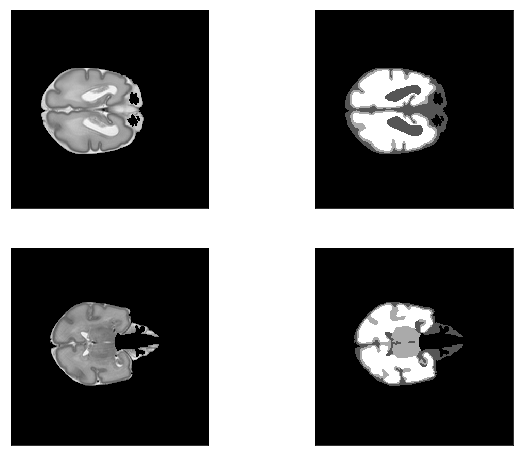

In [4]:
#把这四张图打印出来
_, figs = plt.subplots(2, 2, figsize=(10, 8))
figs[0][0].imshow(im_show1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].imshow(label_show1)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
figs[1][0].imshow(im_show2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].imshow(label_show2)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(im_show1.size)
print(im_show2.size)

先看一下

----

定义一个函数进行图片的读入，设置好数据集的路径（自制的）

根据 `train.txt` 和 `val.txt` 中的文件名进行图片读入，之后根据图片名称生成 batch 的时候再读入图片

In [5]:
M_root = './M'#数据根目录

def read_images(root=M_root, train=True):
    txt_fname = root + '/sets/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'images', i+'.bmp') for i in images]
    label = [os.path.join(root, 'class', i+'.bmp') for i in images]
    return data, label

随机crop图片进行数据增强，从一张图片中 crop 出固定大小的区域，然后在 label 上也做同样方式的crop


定义一个随机crop函数，不仅输出 crop 出来的区域，同时还要输出对应的坐标，便于在 label 上做相同的 crop

In [6]:
def random_crop(data, label, crop_size):
    height, width = crop_size
    data, rect = tfs.RandomCrop((height, width))(data)
    label = tfs.FixedCrop(*rect)(label)
    return data, label

----
验证一下随机 crop

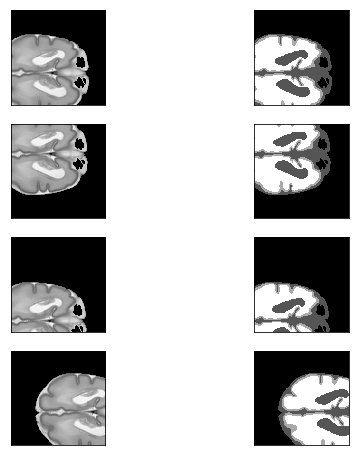

In [7]:
_, figs = plt.subplots(4, 2, figsize=(8, 8))
crop_im1, crop_label1 = random_crop(im_show1, label_show1, (200, 200))
figs[0][0].imshow(crop_im1)
figs[0][1].imshow(crop_label1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
crop_im2, crop_label2 = random_crop(im_show1, label_show1, (200, 200))
figs[1][0].imshow(crop_im2)
figs[1][1].imshow(crop_label2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
crop_im3, crop_label3 = random_crop(im_show1, label_show1, (200, 200))
figs[2][0].imshow(crop_im3)
figs[2][1].imshow(crop_label3)
figs[2][0].axes.get_xaxis().set_visible(False)
figs[2][0].axes.get_yaxis().set_visible(False)
figs[2][1].axes.get_xaxis().set_visible(False)
figs[2][1].axes.get_yaxis().set_visible(False)
crop_im4, crop_label4 = random_crop(im_show1, label_show1, (200, 200))
figs[3][0].imshow(crop_im4)
figs[3][1].imshow(crop_label4)
figs[3][0].axes.get_xaxis().set_visible(False)
figs[3][0].axes.get_yaxis().set_visible(False)
figs[3][1].axes.get_xaxis().set_visible(False)
figs[3][1].axes.get_yaxis().set_visible(False)

----
脑图像中有4种类别，将每种类别与其相应的 RGB 值对应上

In [8]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap = [[0,0,0],[85,85,85],[170,170,170], [255,255,255]]

len(classes), len(colormap)

(4, 4)

建立一个索引，将一个类别的 RGB 值对应到一个整数上

这种一一对应的关系，将 label 图片变成一个和原图片一样大的矩阵，但是只有两个维度，里面的每个数值代表着像素的类别

In [9]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

----
验证一下

先读入一张标签图像

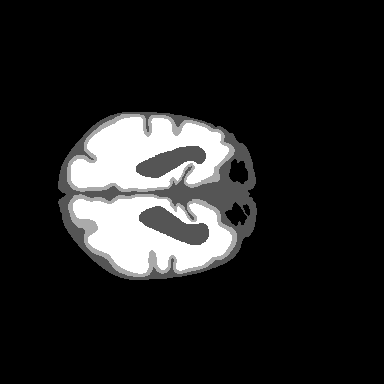

In [10]:
label_im = Image.open('./M/class/(68).bmp').convert('RGB')
label_im

将标签图像转换成标签矩阵

In [11]:
label = image2label(label_im)
label.shape

(384, 384)

标签矩阵的大小即为原图大小

----

输出标签矩阵的一部分

In [12]:
label[110:130, 140:160]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 2, 2, 2, 1, 1, 2,

上面的像素点由 0、1、2、3 构成，0 表示背景，1 表示脑脊液，2 表示灰质，3 表示白质

----

定义数据预处理方式

先随机 crop 出固定大小的区域，然后做标准化

In [13]:
def img_transforms(img, label, crop_size):
    img, label = random_crop(img, label, crop_size)
    img_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

定义一个 MRSegDataset类，构成自定的数据集

In [14]:
class MRSegDataset(Dataset):
    '''
    mr dataset
    '''
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [15]:
# 实例化数据集
input_shape = (384, 384)
mr_train = MRSegDataset(True, input_shape, img_transforms)
mr_test = MRSegDataset(False, input_shape, img_transforms)

train_data = DataLoader(mr_train,16, shuffle=True, num_workers=4)
valid_data = DataLoader(mr_test, 16, num_workers=1)

Read 256 images
Read 48 images


## 二、构造模型

用bilinear kernel作为转置卷积的初始权重 

In [16]:
# 定义 bilinear kernel
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

使用 resnet 34 代替论文中的 vgg 实现 fcn

In [17]:
from mxtorch.vision import model_zoo

In [18]:
# 使用预训练的 resnet 34
pretrained_net = model_zoo.resnet34(pretrained=True)

num_classes = len(classes)

搭建网络

In [19]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
        
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s

In [20]:
net = fcn(num_classes)
net = net.cuda()

# 三、训练

定义一些评估的指标，比如 loss，overal accuracy，mean IOU 等等

In [21]:
from mxtorch.vision.eval_tools import eval_semantic_segmentation

In [22]:
# 定义 loss 和 optimizer
from mxtorch.trainer import ScheduledOptim
criterion = nn.NLLLoss2d()
basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
optimizer = ScheduledOptim(basic_optim)

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


开始训练

In [37]:
for e in range(500):
    if e > 0 and e % 250 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    train_mean_dice = 0
    
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        train_mean_dice += eval_metrics['mdice']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    eval_mean_dice = 0
    
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        labels = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

    eval_acc += eval_metrics['mean_class_accuracy']
    eval_mean_iu += eval_metrics['miou']
    eval_mean_dice += eval_metrics['mdice']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, Train Mean dice: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f},valid Mean dice: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data), train_mean_dice / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu,eval_mean_dice))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Train Loss: 0.08396, Train Acc: 0.73351, Train Mean IU: 0.63401, Train Mean dice: 0.74227, Valid Loss: 0.11206, Valid Acc: 0.66551, Valid Mean IU: 0.57091,valid Mean dice: 0.66547 Time: 0:0:5 lr: 0.001
Epoch: 1, Train Loss: 0.08390, Train Acc: 0.73299, Train Mean IU: 0.63305, Train Mean dice: 0.74095, Valid Loss: 0.11160, Valid Acc: 0.66808, Valid Mean IU: 0.57312,valid Mean dice: 0.66845 Time: 0:0:5 lr: 0.001
Epoch: 2, Train Loss: 0.08370, Train Acc: 0.73312, Train Mean IU: 0.63381, Train Mean dice: 0.74186, Valid Loss: 0.11172, Valid Acc: 0.66715, Valid Mean IU: 0.57250,valid Mean dice: 0.66705 Time: 0:0:5 lr: 0.001
Epoch: 3, Train Loss: 0.08397, Train Acc: 0.73153, Train Mean IU: 0.63191, Train Mean dice: 0.73962, Valid Loss: 0.11217, Valid Acc: 0.66485, Valid Mean IU: 0.57044,valid Mean dice: 0.66497 Time: 0:0:5 lr: 0.001
Epoch: 4, Train Loss: 0.08397, Train Acc: 0.73294, Train Mean IU: 0.63306, Train Mean dice: 0.74074, Valid Loss: 0.11134, Valid Acc: 0.66842, Valid Mean

将参数保存下来

In [42]:
torch.save(net.state_dict(), 'fcn_params(0.7).pth')

# 四、测试

In [38]:
# net.load_state_dict(torch.load('./fcn.pth'))
net = net.eval()

In [39]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap_new = [[0,0,0],[240,255,240],[16,78,139], [205,133,63]]

len(classes), len(colormap)

(4, 4)

In [40]:
# 定义预测函数
cm = np.array(colormap_new).astype('uint8')

def predict(img, label): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

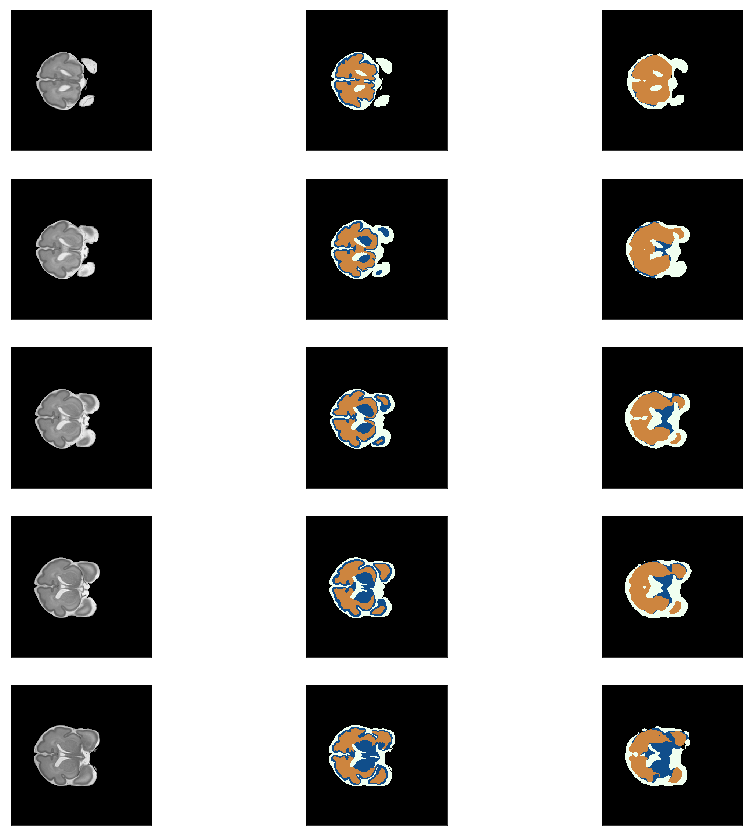

In [41]:
_, figs = plt.subplots(5, 3, figsize=(15, 15))
for i in range(5):
    test_data, test_label = mr_test[i+12]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+12]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)